# Time Series Analysis
This is a mini-project in time-series to refresh econometrics
and time-series forecasting understanding. The original
project was done in R. However, I decided to implement this 
in python and make an interactive version of the assignment 
with streamlit.

## Dataset

<https://www.kaggle.com/uciml/el-nino-dataset>

Dataset used here contains surface meteorological readings 
taken daily from a series of buoys positioned throughout the 
equatorial Pacific. All readings were taken at the same time 
of the day. This data is utitilised for understanding and 
prediction of seasonal-to-inter annual climate variations 
originating in the tropics.

The data under our looking glass spans a period of 4 years — 
from 1 January, 1993 to 31 December, 1996.
There are missing values in the data. Not all buoys were able 
to measure currents, rainfall, and solar radiation, so these 
values are missing dependent on the individual buoy. In order 
to remedy the problem of missing data, we imputed the null 
values using linear interpolation, which admittedly adds bias
to our forecasts.

===================================================================================================================

### Steps:

1. Reading the data into pandas dataframe.

2. Preprocessing:
    - Trimming the table by dropping useless fields
    - Converting datatypes (datetime, float32)
    - Indexing rows with datetime values
    - Imputing missing data by interpolation (linear)
    
3. Plotting observed time-series

4. Decomposing into additive components:
    - Trend
    - Seasonal
    - Residual (noise)
    
5. Seasonally adjusting the time-series

6. Holt-Winters exponential smoothing

7. ARIMA forecasting



In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import warnings
import itertools
from math import sqrt
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

import datetime
import time

import streamlit as st
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore") # specify to ignore warning messages


%matplotlib inline
plt.rcParams['figure.figsize']=(15,6) # set the figure size
plt.rcParams['lines.linewidth'] = 1
# plt.style.use('fivethirtyeight') # using the fivethirtyeight matplotlib theme


# TODO: Modularize the code

## 1. Reading the data into pandas dataframe

In [2]:
# Reading Excel data into dataframe
cols = ['obs', 'year', 'month', 'day', 'date', 'sea_surface_temp']
df = pd.read_excel("./data/elnino.xlsx", header=0, skiprows=0, names=cols)
df.dropna()

# List all fields in the dataframe
print("Columns: {}".format(df.columns.tolist()))

Columns: ['obs', 'year', 'month', 'day', 'date', 'sea_surface_temp']


## 2. Preprocessing

In [3]:
# Converting `date` field to `datetime` object
df['date'] = pd.to_datetime(df['date'], format='%y%m%d')

# Drop irrelevant fields from dataframe
df.drop(['obs', 'year', 'month', 'day'], axis=1, inplace=True)

In [4]:
# We have sea surface temperature data for 4 years

print("\nStart date : {}\nEnd date   : {}".\
      format(df['date'].min(), df['date'].max()))


Start date : 1993-01-01 00:00:00
End date   : 1996-12-31 00:00:00


In [5]:
# Setting index for time-series data
df = df.set_index('date')

In [6]:
# See how many null values are there
df.isnull().sum()

sea_surface_temp    0
dtype: int64

In [7]:
# It shows NO null values.
# But there are some non-float values in the column 'sea_surface_temp'

# Let's see how many non-valid values are there
null_count=0

for value in df['sea_surface_temp']:
    if value == '.':
        null_count += 1
    
print("Null count: {}".format(null_count))

# Making them `nan`
df.loc[df['sea_surface_temp'] == '.', 'sea_surface_temp'] = np.nan

Null count: 22


### Linear interpolation on missing data

In [8]:
df = df.apply(pd.to_numeric, errors='coerce').astype('float64')
df['sea_surface_temp'].interpolate(method='linear', inplace=True)
# Now there are no null
df.isna().sum()

sea_surface_temp    0
dtype: int64

## Weekly series

In [9]:
series = df.resample('W').mean()
series

,sea_surface_temp
date,
1993-01-03,27.270000
1993-01-10,27.285714
1993-01-17,27.487143
1993-01-24,27.634286
1993-01-31,27.690000
...,...
1996-12-08,27.364286
1996-12-15,27.232857
1996-12-22,27.174286


## 3. Plotting observed values

### Daily time series

<AxesSubplot:xlabel='date'>

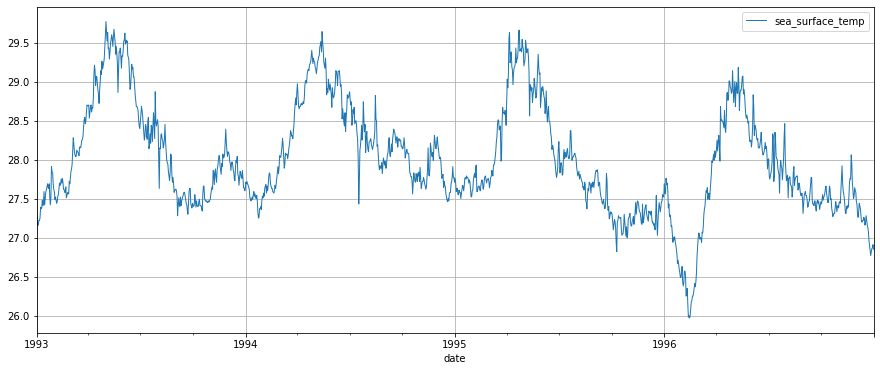

In [10]:
df.plot(grid=True, figsize=(15,6), linewidth=1)

### Weekly time series
Henceforth, we will work on weekly aggregated (mean) data to restrict execution time in ARIMA. 

<AxesSubplot:xlabel='date'>

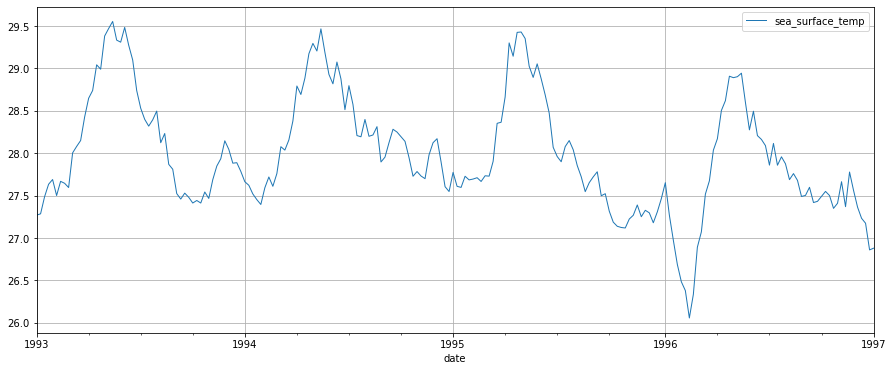

In [11]:
series.plot(grid=True, figsize=(15,6), linewidth=1)

## 4. Decomposing into additive components

In [12]:
decomposition = seasonal_decompose(series, model='additive', period=52)

<AxesSubplot:xlabel='date'>

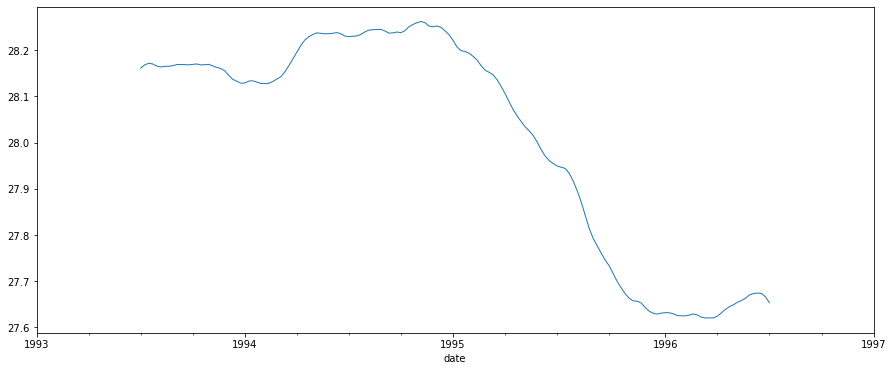

In [13]:
# Trend
decomposition.trend.plot(figsize=(15,6))

<AxesSubplot:xlabel='date'>

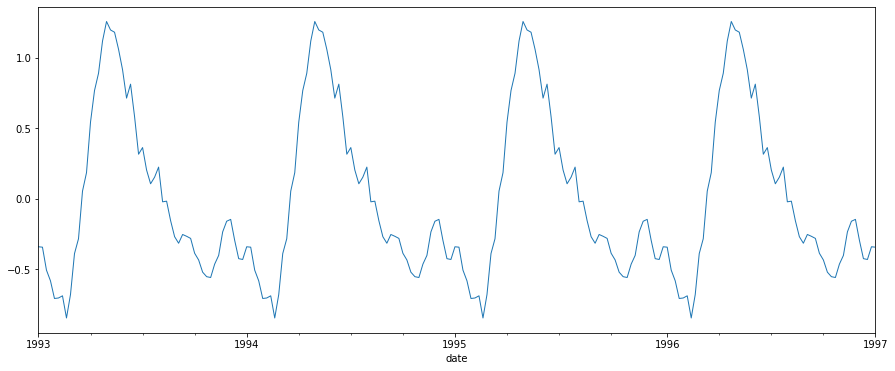

In [14]:
# Seasonal
decomposition.seasonal.plot(figsize=(15,6))

<AxesSubplot:xlabel='date'>

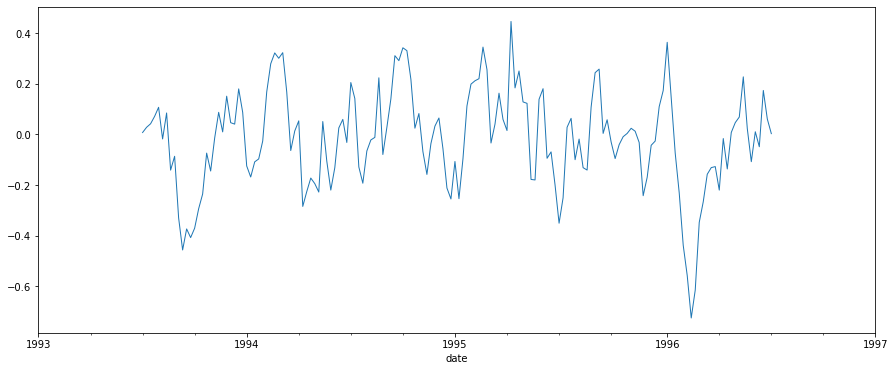

In [15]:
# Residual
decomposition.resid.plot(figsize=(15,6))

## 6. Seasonally adjusting the time series 

<AxesSubplot:xlabel='date'>

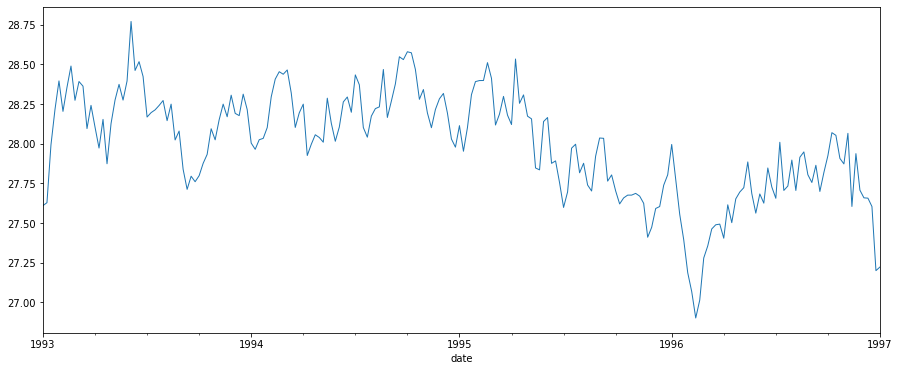

In [16]:
# Plotting time-series without seasonal component

# Simple subtraction works because of additive model
seasonal_adj = decomposition.observed - decomposition.seasonal
seasonal_adj.plot(figsize=(15,6))

## 7. Holt-Winters Exponential Smoothing

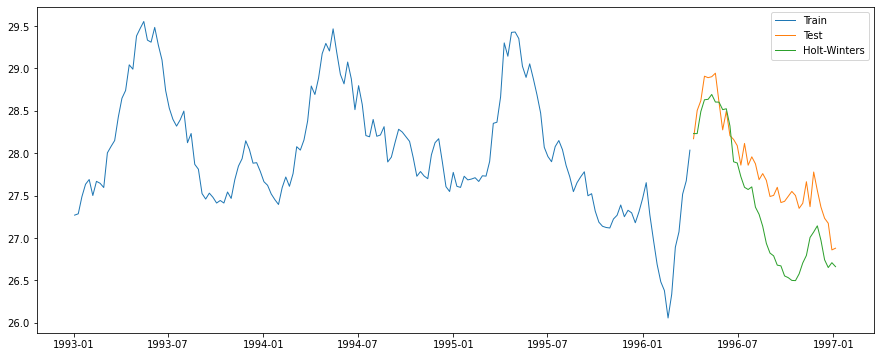

In [17]:
"""" 
With the model being additive, and seasonality present, 
we use Holt-Winters exponential smoothing
"""

# Train-test split (arbitrary)
train, test = series.iloc[:170, 0], series.iloc[170:, 0]

# Create model
model = ExponentialSmoothing(train, freq='W', trend='add', seasonal='add', seasonal_periods=52)
# Fit model
model_fit = model.fit()
# Make prediction
pred = model_fit.predict(start=test.index[0], end=test.index[-1])

# Plot the line graphs
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')


In [18]:
rms = sqrt(mean_squared_error(test, pred))
rms

0.5474816973684179

In [19]:
print(f"P-value: {adfuller(series, autolag='AIC')[1]}")

P-value: 0.031176977717016514


## 7. ARIMA Forecasting

In [20]:
# Time series is stationary

stepwise_model = auto_arima(series, stepwise=True, m=52, trace=True, stationary=True)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=27.19 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=437.175, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=13.66 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=178.285, Time=3.90 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1997.482, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=222.146, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=180.120, Time=17.47 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=inf, Time=16.07 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=194.531, Time=11.48 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=inf, Time=36.59 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=-82.416, Time=12.77 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=-81.957, Time=0.22 sec
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=19.14 sec
 ARIMA(1,0,1)(0,0,2)[52] intercept   : AIC=-86.2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  210
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 52)   Log Likelihood                  51.822
Date:                              Fri, 30 Oct 2020   AIC                            -91.644
Time:                                      20:14:33   BIC                            -71.561
Sample:                                           0   HQIC                           -83.525
                                              - 210                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1930      0.430      0.448      0.654      -0.650       1.037
ar.L1          0.9525      0.022     42.348      0.000       0.908       0.997
ar.S.L52       0.6466      0.456      1.417      0.156      -0.247       1.541
ar.S.L104      0.2076      0.170      1.219      0.223      -0.126       0.541
ma.S.L52      -0.5862      0.544     -1.079      0.281      -1.652       0.479
sigma2         0.0319      0.004      7.212      0.000       0.023       0.041
===================================================================================
Ljung-Box (Q):                       54.16   Jarque-Bera (JB):                 1.07
Prob(Q):                              0.07   Prob(JB):                         0.59
Heteroskedasticity (H):               1.33   Skew:                             0.17
Prob(H) (two-sided):                  0.23   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
params = stepwise_model.get_params()
params

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 0, 1, 52),
 'start_params': None,
 'suppress_warnings': False,
 'trend': None,
 'with_intercept': True}

In [25]:
params = stepwise_model.get_params()
order = params['order']
seasonal_order = params['seasonal_order']

model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)

model_fit = model.fit()
start = len(train)
end = len(train) + len(test) - 1
prediction = model_fit.predict(start=start, end=end)
# prediction.index = series.index[start:end+1]

1996-04-07    28.065055
1996-04-14    28.247274
1996-04-21    28.490113
1996-04-28    28.647659
1996-05-05    28.596898
1996-05-12    28.769621
1996-05-19    28.528002
1996-05-26    28.361166
1996-06-02    28.292867
1996-06-09    28.429278
1996-06-16    28.240127
1996-06-23    27.883619
1996-06-30    28.046051
1996-07-07    27.862249
1996-07-14    27.607191
1996-07-21    27.617316
1996-07-28    27.769176
1996-08-04    27.550854
1996-08-11    27.564990
1996-08-18    27.562044
1996-08-25    27.265917
1996-09-01    27.271569
1996-09-08    27.391004
1996-09-15    27.485270
1996-09-22    27.457086
1996-09-29    27.384792
1996-10-06    27.336391
1996-10-13    27.189105
1996-10-20    27.049151
1996-10-27    27.077287
1996-11-03    27.084341
1996-11-10    27.090830
1996-11-17    27.319659
1996-11-24    27.439372
1996-12-01    27.466224
1996-12-08    27.242174
1996-12-15    27.019751
1996-12-22    26.977108
1996-12-29    27.138015
1997-01-05    27.031489
Freq: W-SUN, dtype: float64

<AxesSubplot:xlabel='date'>

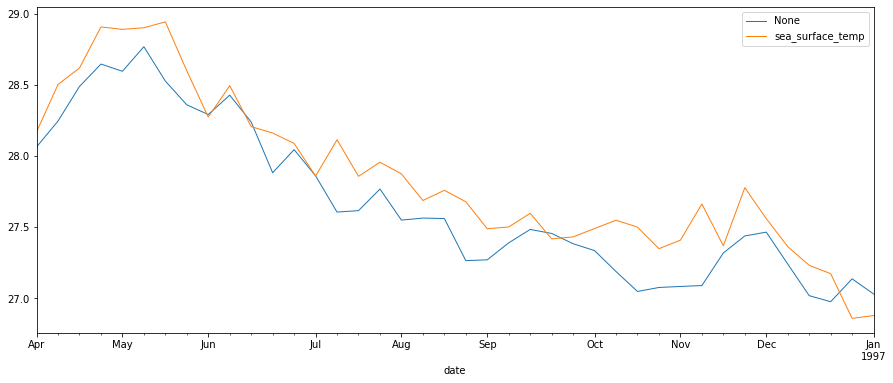

In [26]:
# New plot
prediction.plot(legend=True)
test.plot(legend=True)

In [28]:
rmse = sqrt(mean_squared_error(test, prediction))
print(f"RMSE: {rmse}")
print(f"Series mean: {series['sea_surface_temp'].mean()}")

RMSE: 0.2518798514782895
Series mean: 27.991914965986396


<AxesSubplot:>

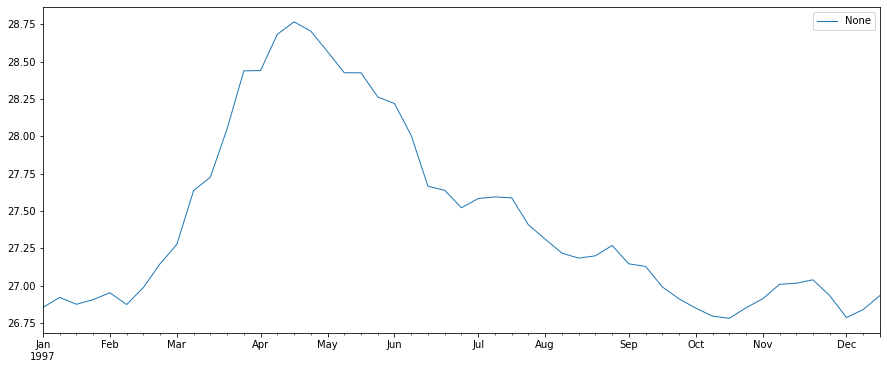

In [29]:
input_weeks = 50

forecast_model = SARIMAX(series, order=order, 
                  seasonal_order=seasonal_order,
                  enforce_stationarity=False, enforce_invertibility=False)

forecast_fit = forecast_model.fit()

forecast = forecast_fit.predict(start=len(series), end=len(series)+input_weeks)
forecast.index = pd.date_range(series.index[-1], periods= input_weeks+1, freq='W')

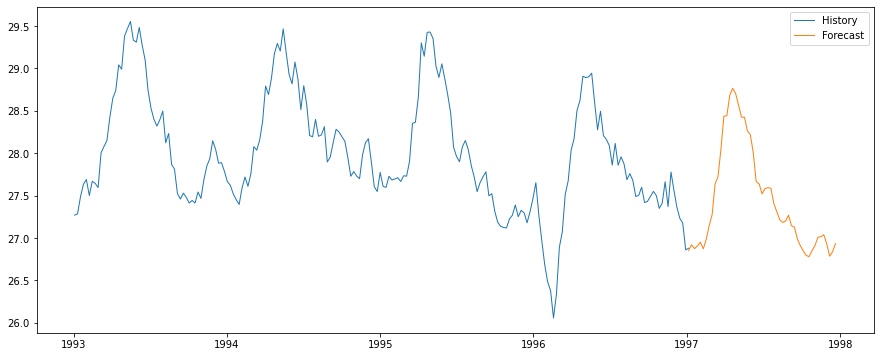

In [30]:
plt.plot(series.index, series, label='History')
plt.plot(forecast.index, forecast, label='Forecast')
plt.legend(loc='best')